Importing

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import cmocean.cm as cm

Dataset Inspection

In [2]:
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1d_20221031_20221031_grid_T.nc')
ds

# Definition of variables
temp = ds.votemper 
saline = ds.vosaline

In [3]:
# # Xarray implementation

# # First we stack (flatten) temp and saline, then we combine (concat) them in a single dataarray
# test = xr.concat([temp[0,0].stack(z=("x", "y")),saline[0,0].stack(z=("x", "y"))], dim = 'j')

# test = test.fillna(test)
# test=test.transpose()

Data wrangling

In [4]:
a = np.stack((temp[0,0].values.flatten(), saline[0,0].values.flatten()))
a = np.nan_to_num(a)

# Define the value for unwanted data (land and nans)
a = np.where(a==0, 0, a)

a = np.transpose(a)

SOM - Matrix Grid

In [5]:
temp_som = SOM(m=3, n=3, dim=2)
temp_som.fit(a)
predictions = temp_som.predict(a)

# Post processing 

unique_m, counts_m = np.unique(predictions, return_counts=True)

# Finding the unwanted cluster
unique_m[counts_m.argmax()]

predictions = np.where(predictions==unique_m[counts_m.argmax()], np.nan, predictions)
predictions = np.reshape(predictions,(898,398))
som_m = xr.DataArray(predictions,
                   coords = {'y': temp[0,0].y, 'x': temp[0,0].x},
                   dims = ['y','x'],
                   attrs=dict(description="Clusters of the performed self organizing map algorithm",
                              name ="Cluster",
                              units="count"),
                   )  

SOM - Vector Grid

In [6]:
temp_som = SOM(m=9, n=1, dim=2)
temp_som.fit(a)
predictions = temp_som.predict(a)

# Post processing 

unique_v, counts_v = np.unique(predictions, return_counts=True)

# Finding the unwanted cluster
unique_v[counts_v.argmax()]

predictions = np.where(predictions==unique_v[counts_v.argmax()], np.nan, predictions)
predictions = np.reshape(predictions,(898,398))
som_v = xr.DataArray(predictions,
                   coords = {'y': temp[0,0].y, 'x': temp[0,0].x},
                   dims = ['y','x'],
                   attrs=dict(description="Clusters of the performed self organizing map algorithm",
                              name ="Cluster",
                              units="count"),
                   )  

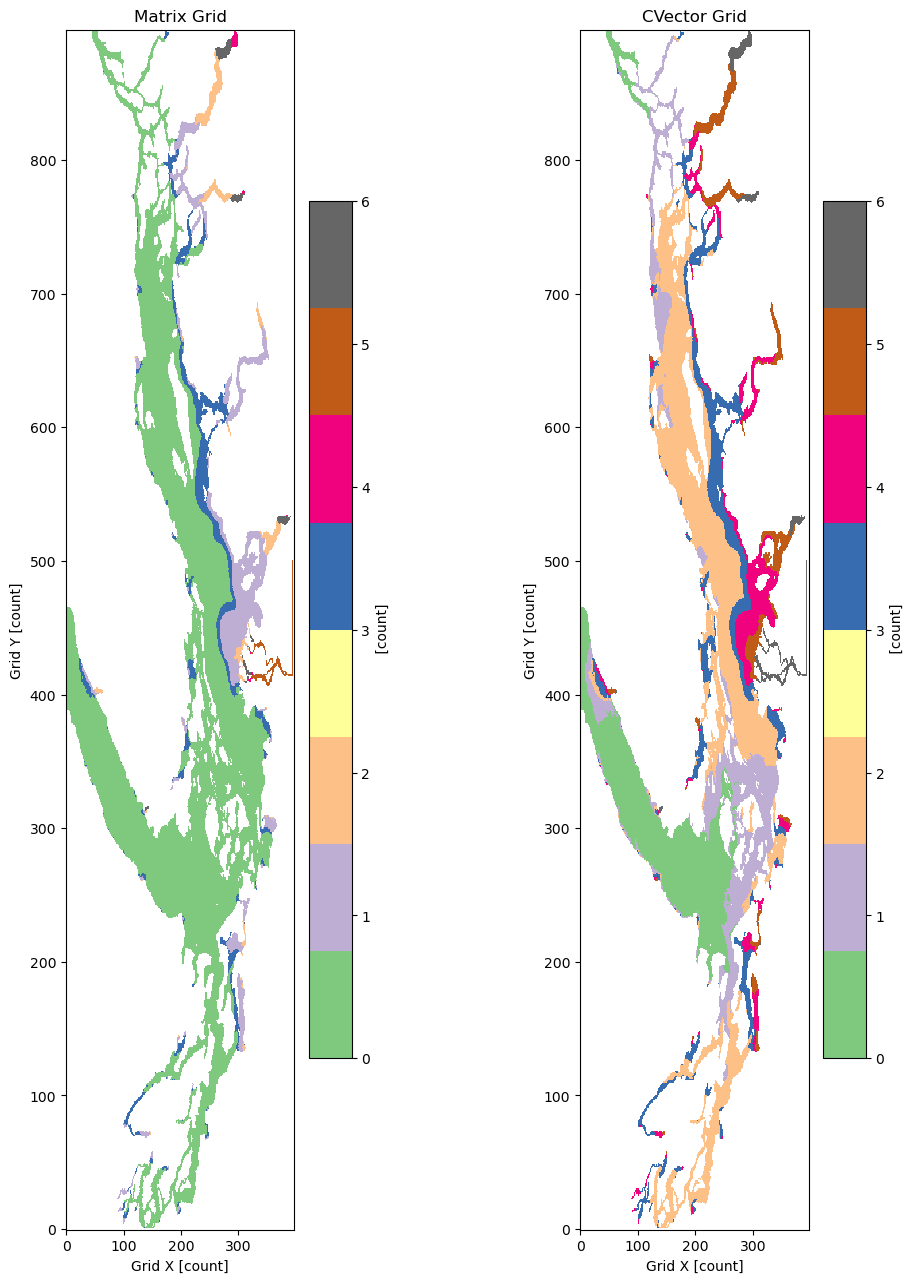

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 15))
cmap = 'Accent'
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)

som_m.plot(ax=ax[0], cmap=cmap)
som_v.plot(ax=ax[1], cmap=cmap)
ax[0].title.set_text('Matrix Grid')
ax[1].title.set_text('Vector Grid')


